In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams,font_manager
from matplotlib.ticker import FormatStrFormatter
import json
import pandas as pd
import subprocess
import os

%load_ext autoreload
%autoreload 2

In [2]:
rcParams['figure.figsize'] = (6,6) #figure size in inches
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size'] 

In [3]:
direc = 'H:/.shortcut-targets-by-id/1R8CaJc_5SkyYuvNB8yd4KCaXFKSi2zoz/2022 Time pressure replication/Data/'

In [4]:
def load_json_data(direc,filename):
    with open(direc + filename) as f:
        return json.load(f)

In [5]:
json_data = [load_json_data(direc,f) for f in os.listdir(direc) if f.endswith('.json')]

In [6]:
condition_dict = dict(sum([[(e['user_name'],str(e['event_info']['condition'])) for e in d if e['event_type']=='Select condition'] 
          for d in json_data],[]))

In [36]:
condition_dict

{'20220630_dn': 'random',
 '20220630_hz': '[0, 2, 1]',
 '20220701_ot': '[0, 1, 2]',
 '20220701_yl': '[1, 0, 2]',
 '20220701_xl': '[0, 1, 2]',
 '20220701_ar': 'random',
 '20220701_hl': '[2, 1, 0]',
 '20220705_tl': '[0, 2, 1]',
 '20220705_ar2': 'random',
 '20220705_ao': '[0, 1, 2]',
 '20220705_cm': 'random',
 '20220706_kt': 'random',
 '20220706_cb': 'random',
 '20220706_kg': '[0, 1, 2]',
 '20220706_ll': 'random',
 '20220706_nl': '[2, 0, 1]',
 '20220706_bg': 'random',
 '20220706_hr': '[0, 2, 1]',
 '20220706_bh': '[1, 0, 2]',
 '20220706_rl': 'random',
 '20220707_wjk': 'random',
 '20220707_vb': 'random',
 '20220707_sw': '[1, 2, 0]',
 '20220707_il': '[2, 1, 0]',
 '20220707_mm': '[0, 2, 1]',
 '20220707_jn': 'random',
 '20220708_pp': '[2, 0, 1]',
 '20220708_sc': '[1, 2, 0]',
 '20220708_lp': 'random',
 '20220708_jk': '[2, 0, 1]',
 '20220711_gl': 'random',
 '20220711_kc': '[1, 2, 0]',
 '20220711_re': 'random',
 '20220711_pb': 'random',
 '20220711_ch': 'random',
 '20220712_va': 'random',
 '202207

In [7]:
def load_data_for_elo(direc,filename):
    with open(direc + filename) as f:
        data = json.load(f)
        #print([e['event_info']['trial_number'] for e in data if e['event_type']=='Timeout' and e['event_info']['timer_id']=='visTimerOpp'])
        #print(np.unique([e['event_info']['time_limit'] for e in data if e['event_type']=='Time drawn'],return_counts=True))
        event_types = ['Make player move','Make opponent move','Timeout']
        df = pd.DataFrame([{'user_name' : e['user_name'],'event_type' : e['event_type'],**e['event_info']} 
                           for e in data if e['event_type'] in event_types and 
                           (not 'status' in e['event_info'] or e['event_info']['status']!='playing')])
        df['time_limit']=pd.DataFrame([e['event_info'] for e in data if e['event_type']=='Time drawn']
                           ).set_index('trial_number').loc[df['trial_number']]['time_limit'].reset_index(drop=True)
        return df

In [8]:
df_for_elo = pd.concat([load_data_for_elo(direc,f) for f in os.listdir(direc) if f.endswith('.json')]).reset_index(drop=True)


In [9]:
def get_results_from_row(row):
    user_name = row['user_name'] + '_' + str(row['time_limit'])
    opp = 'comp{:03d}'.format(row['opponent'])
    if row['event_type']=='Make player move':        
        if row['color']==0:
            black = user_name
            white = opp
            outcome = 1
        else:
            black = opp
            white = user_name
            outcome = -1
        if row['status']=='draw':
            outcome=0
    elif row['event_type']=='Make opponent move':        
        if row['opponent_color']==0:
            black = opp
            white = user_name
            outcome = 1
        else:
            black = user_name
            white = opp
            outcome = -1
        if row['status']=='draw':
            outcome=0
    else: 
        if row['color']==0:
            black = user_name
            white = opp
            outcome = -1
        else:
            black = opp
            white = user_name
            outcome = 1
    return [str(black),str(white),outcome]

In [33]:
results = list(df_for_elo.apply(get_results_from_row,axis=1))

In [35]:
with open('G:/My Drive/Bas Games/Analysis/Ratings/results_time_rep.txt','w') as f:
    json.dump(results,f)

In [11]:
def load_data(direc,filename):
    print(filename)
    with open(direc + filename) as f:
        data = json.load(f)
        #print([e['event_info']['trial_number'] for e in data if e['event_type']=='Timeout' and e['event_info']['timer_id']=='visTimerOpp'])
        #print(np.unique([e['event_info']['time_limit'] for e in data if e['event_type']=='Time drawn'],return_counts=True))
        
        df = pd.DataFrame([e['event_info'] for e in data if e['event_type']=='Make player move'])
        df['user_name'] = [e['user_name'] for e in data if e['event_type']=='Make player move']        
        df['time_limit']=pd.DataFrame([e['event_info'] for e in data if e['event_type']=='Time drawn']
                           ).set_index('trial_number').loc[df['trial_number']]['time_limit'].reset_index(drop=True)
        return df

In [12]:
def encode_board(pieces):
    return np.sum([2**i for i,p in enumerate(pieces) if p=='1']).astype(np.int64)

def encode_move(m):
    return 2**m

In [13]:
df = pd.concat([load_data(direc,f) for f in os.listdir(direc) if f.endswith('.json')]).reset_index(drop=True)
df['user_number'] = df['user_name'].map(dict(zip(df['user_name'].unique(),range(61))))
df['time_limit_number'] = df['time_limit'].map(dict(zip(sorted(df['time_limit'].unique()),range(61))))
df['user_id'] = 3*df['user_number'] + df['time_limit_number']
for i in df['user_id'].unique():
    n = (df['user_id']==i).sum()
    df.loc[df['user_id']==i,'group'] = (5*(np.random.permutation(n)/n)+1)
df['group']=df['group'].astype(int)
df['color'] = df['color'].map({0: 'Black', 1: 'White'})
df['bp']=df['bp'].apply(encode_board)
df['wp']=df['wp'].apply(encode_board)
df['move']=2**df['move']


20220630_dn_Fourinarow_1656598804921.json
20220630_hz_Fourinarow_1656619392350.json
20220701_ot_Fourinarow_1656684693552.json
20220701_yl_Fourinarow_1656685238367.json
20220701_xl_Fourinarow_1656690409863.json
20220701_ar_Fourinarow_1656695570122.json
20220701_hl_Fourinarow_1656705552623.json
20220705_tl_Fourinarow_1657031758097.json
20220705_ar2_Fourinarow_1657037007906.json
20220705_ao_Fourinarow_1657042202277.json
20220705_cm_Fourinarow_1657046283966.json
20220706_kt_Fourinarow_1657116555776.json
20220706_cb_Fourinarow_1657121683465.json
20220706_kg_Fourinarow_1657122320617.json
20220706_ll_Fourinarow_1657127224653.json
20220706_nl_Fourinarow_1657127738072.json
20220706_bg_Fourinarow_1657132516301.json
20220706_hr_Fourinarow_1657133440632.json
20220706_bh_Fourinarow_1657139253932.json
20220706_rl_Fourinarow_1657139038897.json
20220707_wjk_Fourinarow_1657203749368.json
20220707_vb_Fourinarow_1657209556290.json
20220707_sw_Fourinarow_1657214209050.json
20220707_il_Fourinarow_165721965

In [14]:
names_from_sheet = ['20220630_dn','20220714_jf','20220630_hz','20220701_yl','20220701_ot','20220701_xl','20220701_ar','20220707_vb','20220707_wjk','20220701_hl','20220714_sh','20220705_ce','20220705_tl','20220705_ar2','20220707_sw','20220705_ao','20220705_cm','20220707_jn','20220706_kt','20220706_cb','20220706_kg','20220706_ll','20220706_nl','20220706_bg','20220706_hr','20220706_rl','20220706_bh','20220707_il','20220707_mm','20220708_pp','20220708_lp','20220708_jk','20220708_sc','20220711_kc','20220711_gl','20220711_re','20220711_pb','20220711_ch','20220712_km','20220712_va','20220712_ms','20220712_yd','20220712_ss','20220712_km2','20220712_ih','20220713_aq','20220713_st','20220714_zm','20220714_cm','20220715_ab','20220715_mo','20220715_zz','20220715_yf','20220718_aw','20220718_yz','20220718_aj','20220720_ae','20220720_mm','20220720_cc','20220721_ag','20220722_rz']

In [15]:
set(names_from_sheet) - set(condition_dict.keys())

{'20220705_ce'}

In [16]:
set(condition_dict.keys()) - set(names_from_sheet)

set()

In [21]:
len(json_data)

60

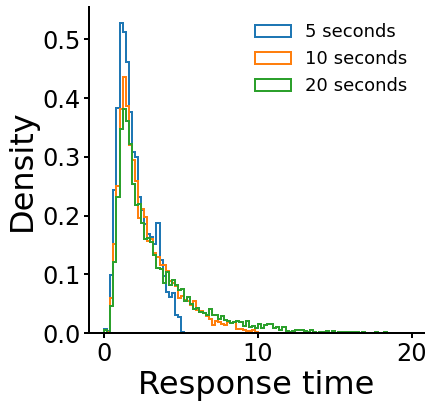

In [18]:
for i in [5000,10000,20000]:
    plt.hist(df[(df['time_limit']==i)]['duration']/1000,density='normed',bins=np.arange(0,20,0.2),histtype='step',linewidth=2,label=str(i//1000) + ' seconds')
plt.legend()
plt.xlabel('Response time')
plt.ylabel('Density')
plt.show()

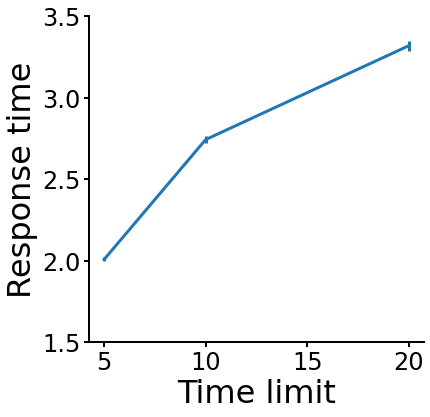

In [19]:
m = df.groupby('time_limit')['duration'].mean().values
sem = df.groupby('time_limit')['duration'].sem().values
plt.errorbar([5,10,20],m/1000,sem/1000)
plt.xlabel('Time limit')
plt.ylabel('Response time')
plt.ylim([1.5,3.5])
plt.show()

In [20]:
direc = 'C:/Users/svo/Documents/FourinarowData/Data/timepressure_rep/'
cols = ['bp','wp','color','move','duration','group','user_name',]
if not os.path.exists(direc + 'splits/'):
    os.mkdir(direc + 'splits/')
for i in range(180):
    if not os.path.exists(direc + 'splits/' + str(i+1)):
        os.mkdir(direc + 'splits/' + str(i+1))
    with open(direc + 'splits/' + str(i+1) + '/data.csv','w') as f:
        f.write(df[df['user_id']==i][cols].to_csv(None, index = False, header=False,sep='\t',line_terminator ='\n')[:-1])
    for g in range(1,6):
        with open(direc + 'splits/' + str(i+1) + '/' + str(g) + '.csv','w') as f:
            f.write(df[(df['user_id']==i) & (df['group']==g)][cols].to_csv(None, index = False, header=False,sep='\t',line_terminator ='\n')[:-1])